## This is the softmax workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

The goal of this workbook is to give you experience with training a softmax classifier.

In [1]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '../cifar-10-batches-py' # You need to update this line
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [3]:
from nndl import Softmax

In [4]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [17]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [18]:

print(loss)

2.3277607028048966


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this make sense?

## Answer:

The loss is relatively small in magnitude since we are taking the log of the averaged loss.

#### Softmax gradient

In [24]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: -0.739617 analytic: -0.739617, relative error: 5.869846e-08
numerical: 1.976717 analytic: 1.976717, relative error: 3.426518e-08
numerical: 1.148625 analytic: 1.148625, relative error: 1.220217e-08
numerical: -2.225346 analytic: -2.225346, relative error: 1.370702e-08
numerical: 1.433704 analytic: 1.433704, relative error: 1.796452e-08
numerical: 2.102476 analytic: 2.102476, relative error: 3.654550e-08
numerical: -0.945742 analytic: -0.945742, relative error: 2.820375e-08
numerical: -1.673712 analytic: -1.673712, relative error: 2.339767e-08
numerical: 1.042815 analytic: 1.042815, relative error: 2.259348e-08
numerical: 1.151928 analytic: 1.151928, relative error: 1.744574e-08


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [25]:
import time
print(grad.shape)
print(X_train.shape)

(10, 3073)
(49000, 3073)


In [26]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.3280907427091253 / 343.2056899171455 computed in 0.0509340763092041s
Vectorized loss / grad: 2.3280907427091235 / 343.20568991714555 computed in 0.0049059391021728516s
difference in loss / grad: 1.7763568394002505e-15 /2.339374734623335e-13 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

iteration 0 / 1500: loss 2.2764551353551408
iteration 100 / 1500: loss 2.081742628965037
iteration 200 / 1500: loss 1.968296042091064
iteration 300 / 1500: loss 1.9512785118184592
iteration 400 / 1500: loss 1.880116936558337
iteration 500 / 1500: loss 1.797482035676265
iteration 600 / 1500: loss 1.8017495585902168
iteration 700 / 1500: loss 1.8412010671818828
iteration 800 / 1500: loss 1.7691886577962912
iteration 900 / 1500: loss 1.8286663247616388
iteration 1000 / 1500: loss 1.8095484993348476
iteration 1100 / 1500: loss 1.7895031868336235
iteration 1200 / 1500: loss 1.879544765396779
iteration 1300 / 1500: loss 1.8630129054196396
iteration 1400 / 1500: loss 1.906853030716955
That took 6.162401914596558s


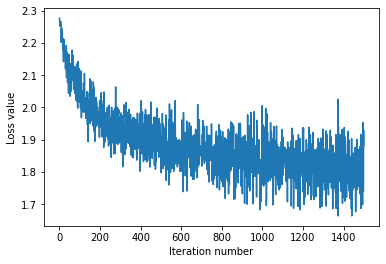

In [27]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time

tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [30]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.3808979591836735
validation accuracy: 0.388


## Optimize the softmax classifier

In [31]:
np.finfo(float).eps

2.220446049250313e-16

In [42]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #

learning_rates = [1e-7, 1e-6, 1e-5, 1e-4]
num_iter = 1500
losses = []
accs = []

for i, lr in enumerate(learning_rates):

    # train softmax classifier
    loss_hist = softmax.train(X_train, y_train, learning_rate=lr, num_iters=num_iter, verbose=False)
    
    losses.append(loss_hist)
    y_val_pred = softmax.predict(X_val)
    acc = np.mean(np.equal(y_val, y_val_pred))
    accs.append(acc)
    
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


iteration 0 / 1500: loss 2.3747802256659782
iteration 100 / 1500: loss 2.0794240163509254
iteration 200 / 1500: loss 1.9864266880878103
iteration 300 / 1500: loss 1.9738263455240033
iteration 400 / 1500: loss 1.9356773472872708
iteration 500 / 1500: loss 1.704373387557565
iteration 600 / 1500: loss 1.7980161366865106
iteration 700 / 1500: loss 1.850510294214842
iteration 800 / 1500: loss 1.7456330489686425
iteration 900 / 1500: loss 1.8456693179897774
iteration 1000 / 1500: loss 1.8738813545607216
iteration 1100 / 1500: loss 1.8540927800832014
iteration 1200 / 1500: loss 1.828715342363835
iteration 1300 / 1500: loss 1.772773767429569
iteration 1400 / 1500: loss 1.8805778388870595
iteration 0 / 1500: loss 2.3824389619657724
iteration 100 / 1500: loss 1.8507991548201728
iteration 200 / 1500: loss 1.8359986116005456
iteration 300 / 1500: loss 1.7318642933793853
iteration 400 / 1500: loss 1.7044799494772587
iteration 500 / 1500: loss 1.7099036063742812
iteration 600 / 1500: loss 1.66905266

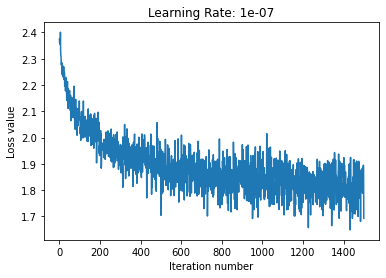

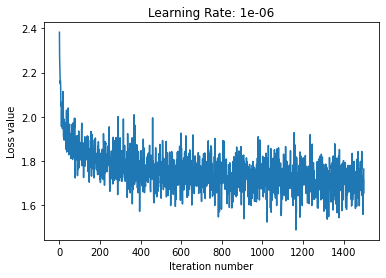

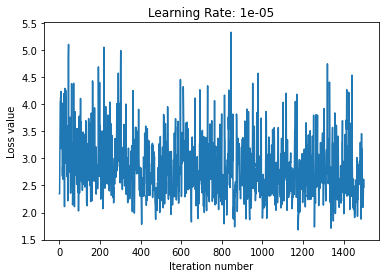

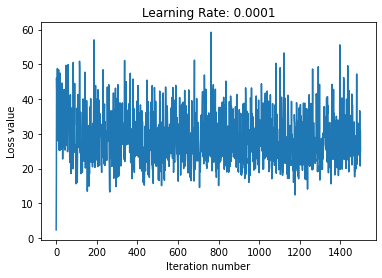

In [43]:
for i, lr in enumerate(learning_rates):
    plt.title("Learning Rate: " + str(lr))
    plt.plot(losses[i])
    plt.xlabel('Iteration number')
    plt.ylabel('Loss value')
    plt.show()
    plt.figure
    

In [47]:
print("Accuracies:", accs)
index = np.argmax(accs)
print(index)
print("Optimal LR:", learning_rates[index])
print('Best acc:', accs[index])

Accuracies: [0.392, 0.405, 0.305, 0.259]
1
Optimal LR: 1e-06
Best acc: 0.405


# Python Code .py

In [ ]:
import numpy as np


class Softmax(object):

  def __init__(self, dims=[10, 3073]):
    self.init_weights(dims=dims)

  def init_weights(self, dims):
    """
    Initializes the weight matrix of the Softmax classifier.  
    Note that it has shape (C, D) where C is the number of 
    classes and D is the feature size.
    """
    self.W = np.random.normal(size=dims) * 0.0001

  def loss(self, X, y):
    """
    Calculates the softmax loss.
  
    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.
  
    Inputs:
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
  
    Returns a tuple of:
    - loss as single float
    """

    # Initialize the loss to zero.
    loss = 0.0

    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the normalized softmax loss.  Store it as the variable loss.
    #   (That is, calculate the sum of the losses of all the training 
    #   set margins, and then normalize the loss by the number of 
    #   training examples.)
    # ================================================================ #
    
    
    size = X.shape[0]
    num_classes = len(np.unique(y))
    
    # for i in range(size):
    #   term = 0
    #   for j in range(num_classes):
    #     term += np.exp(self.W[j] * X[i])
    #   loss += (self.W[i] * X[i]) - np.log(term)
    
    '''
    score = np.dot(X, self.W.T) 
    score -= np.max(score, axis=1, keepdims=True) # use numerical stability
    exp_ = np.exp(score)
    probabilities = exp_ / np.sum(exp_, axis=1, keepdims=True)
    probabilities = probabilities[np.arange(size), y]
    loss = -np.sum(np.log(probabilities))
    '''

    score = X @ self.W.T
    for i, x in enumerate(score):
      x -= np.max(x) # numerical stability
      probability = np.exp(x[y[i]]) / np.sum(np.exp(x))
      loss += -np.log(probability)
        
    loss /= size

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return loss

  def loss_and_grad(self, X, y):
    """
    Same as self.loss(X, y), except that it also returns the gradient.

    Output: grad -- a matrix of the same dimensions as W containing 
      the gradient of the loss with respect to W.
    """

    # Initialize the loss and gradient to zero.
    loss = 0.0
    grad = np.zeros_like(self.W)
    
    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the softmax loss and the gradient. Store the gradient
    #   as the variable grad.
    # ================================================================ #

    num_classes = len(np.unique(y))
    size = X.shape[0]

    score = np.dot(X, self.W.T)

    for i, x in enumerate(score):
      x -= np.max(x) # numerical stability
      probability = np.exp(x[y[i]]) / np.sum(np.exp(x))
      loss += -np.log(probability)

      for j in range(num_classes):
        softmax = np.exp(x[j]) / np.sum(np.exp(x))
        #grad[j] += X[i] * (softmax - (j == y[j]))
        if j == y[i]:
          grad[j] += X[i] * (softmax - 1)
        else:
          grad[j] += X[i] * (softmax)

    grad /= size
    loss /= size
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return loss, grad

  def grad_check_sparse(self, X, y, your_grad, num_checks=10, h=1e-5):
    """
    sample a few random elements and only return numerical
    in these dimensions.
    """
  
    for i in np.arange(num_checks):
      ix = tuple([np.random.randint(m) for m in self.W.shape])
  
      oldval = self.W[ix]
      self.W[ix] = oldval + h # increment by h
      fxph = self.loss(X, y)
      self.W[ix] = oldval - h # decrement by h
      fxmh = self.loss(X,y) # evaluate f(x - h)
      self.W[ix] = oldval # reset
  
      grad_numerical = (fxph - fxmh) / (2 * h)
      grad_analytic = your_grad[ix]
      rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
      print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

  def fast_loss_and_grad(self, X, y):
    """
    A vectorized implementation of loss_and_grad. It shares the same
    inputs and ouptuts as loss_and_grad.
    """
    loss = 0.0
    grad = np.zeros(self.W.shape) # initialize the gradient as zero
  
    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the softmax loss and gradient WITHOUT any for loops.
    # ================================================================ #
    
    size = X.shape[0]
    score = np.dot(X, self.W.T) 
    #score -= np.max(score, axis=1, keepdims=True) # use numerical stability

    # find softmax
    exp_ = np.exp(score)
    probabilities = exp_ / np.sum(exp_, axis=1, keepdims=True)
    loss = -np.sum(np.log(probabilities[np.arange(size), y]))
    loss /= size

    probabilities[np.arange(size), y] -= 1 # for i != j case of loss function
    #print(probabilities.shape)
    #print(X.shape)
    grad = probabilities.T @ X
    grad /= size

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return loss, grad

  def train(self, X, y, learning_rate=1e-3, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
    A list containing the value of the loss function at each training iteration.
    """
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes

    self.init_weights(dims=[np.max(y) + 1, X.shape[1]])	# initializes the weights of self.W

    # Run stochastic gradient descent to optimize W
    loss_history = []

    for it in np.arange(num_iters):
      X_batch = None
      y_batch = None

      # ================================================================ #
      # YOUR CODE HERE:
      #   Sample batch_size elements from the training data for use in 
      #     gradient descent.  After sampling,
      #     - X_batch should have shape: (batch_size, dim)
      #     - y_batch should have shape: (batch_size,)
      #   The indices should be randomly generated to reduce correlations
      #   in the dataset.  Use np.random.choice.  It's okay to sample with
      #   replacement.
      # ================================================================ #
      
      idx = np.random.choice(num_train, batch_size, replace=True)
      X_batch = X[idx]
      y_batch = y[idx]

      # ================================================================ #
      # END YOUR CODE HERE
      # ================================================================ #

      # evaluate loss and gradient
      loss, grad = self.fast_loss_and_grad(X_batch, y_batch)
      loss_history.append(loss)

      # ================================================================ #
      # YOUR CODE HERE:
      #   Update the parameters, self.W, with a gradient step 
      # ================================================================ #
       
      self.W = self.W - learning_rate*grad

      # ================================================================ #
      # END YOUR CODE HERE
      # ================================================================ #

      if verbose and it % 100 == 0:
        print('iteration {} / {}: loss {}'.format(it, num_iters, loss))

    return loss_history

  def predict(self, X):
    """
    Inputs:
    - X: N x D array of training data. Each row is a D-dimensional point.

    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[1])
    # ================================================================ #
    # YOUR CODE HERE:
    #   Predict the labels given the training data.
    # ================================================================ #
    
    score = X @ self.W.T
    exp_ = np.exp(score)
    probabilities = exp_ / np.sum(exp_, axis=1, keepdims=True)
    y_pred = np.argmax(probabilities, axis=1)

    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return y_pred

